In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import random

In [43]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [44]:
def generate_nonlinear_data(samples=1000, noise=0.3, function_type='sine'):
    X = np.random.uniform(-3, 3, (samples, 1))
    
    if function_type == 'sine':
        y = np.sin(X) + np.random.normal(0, noise, (samples, 1))
    elif function_type == 'quadratic':
        y = X**2 + np.random.normal(0, noise, (samples, 1))
    elif function_type == 'exponential':
        y = np.exp(X) / 10 + np.random.normal(0, noise, (samples, 1))
    
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    
    train_size = int(0.8 * samples)
    X_train, y_train = X_tensor[:train_size], y_tensor[:train_size]
    X_test, y_test = X_tensor[train_size:], y_tensor[train_size:]
    
    return X_train, y_train, X_test, y_test, X, y


$$y = \sin(x) + \text{шум}$$
$$y=x^2+шум$$
$$y = \frac{e^x}{10} + шум$$

Каждый набор данных случайно выбирает 𝑥 из диапазона 
[−3,3], добавляет шум и делит выборку на тренировочную и тестовую части (80% к 20%)

In [45]:
class NonLinearRegressionModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim1=32, hidden_dim2=16, output_dim=1, 
                 use_batch_norm=False, dropout_rate=0.0):
        super(NonLinearRegressionModel, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        if use_batch_norm:
            self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        return x

Первый слой: `nn.Linear(input_dim=1, hidden_dim1=32)`

Второй слой: `nn.Linear(hidden_dim1=32, hidden_dim2=16)`

Выходной слой: `nn.Linear(hidden_dim2=16, output_dim=1)`


Линейные слои (Linear) выполняют линейное преобразование:

$$ℎ=𝑊𝑥+𝑏$$
$$ReLU(h)=max(0,h)$$

формула батч норма:

$$
\hat{x} = \frac{x - \mu_{\text{batch}}}{\sigma_{\text{batch}}}, \quad y = \gamma \hat{x} + \beta
$$

где $\mu_{\text{batch}}$ и $\sigma_{\text{batch}}$ – среднее и дисперсия по батчу, а $\gamma$ и $\beta$ – обучаемые параметры




In [46]:
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    
    return losses

In [47]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = nn.MSELoss()(predictions, y_test).item()
    return mse, predictions

In [48]:
def run_batch_size_experiments(X_train, y_train, X_test, y_test, batch_sizes=None):
    if batch_sizes is None:
        batch_sizes = [16, 32, 64]
    results = {}
    best_batch_size = None
    best_mse = float('inf')
    
    for batch_size in batch_sizes:
        print(f"\nОбучение с размером батча: {batch_size}")
        
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        model = NonLinearRegressionModel(use_batch_norm=True, dropout_rate=0.0)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        train_losses = train_model(model, train_loader, criterion, optimizer, epochs=100)
        
        mse, predictions = evaluate_model(model, X_test, y_test)
        print(f"Размер батча: {batch_size}, тестовая MSE: {mse:.4f}")
        
        results[batch_size] = {
            'model': model,
            'train_losses': train_losses,
            'mse': mse,
            'predictions': predictions
        }
        
        if mse < best_mse:
            best_mse = mse
            best_batch_size = batch_size
    
    return results, best_batch_size


$$
MSE = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2
$$

В качестве функции ошибки использую `nn.MSELoss()`, а оптимизатор — `Adam` с фиксированным шагом обучения (`learning rate` = `0.001`).

In [49]:
def run_configuration_experiments(X_train, y_train, X_test, y_test, best_batch_size):
    configurations = {
        '- BN, - Dropout': {'use_batch_norm': False, 'dropout_rate': 0.0},
        '+ BN, - Dropout': {'use_batch_norm': True, 'dropout_rate': 0.0},
        '- BN, + Dropout': {'use_batch_norm': False, 'dropout_rate': 0.2},
        '+ BN, + Dropout': {'use_batch_norm': True, 'dropout_rate': 0.2}
    }
    
    results = {}
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
    
    for config_name, config_params in configurations.items():
        print(f"\nОбучения с конфигом: {config_name}")
        
        model = NonLinearRegressionModel(use_batch_norm=config_params['use_batch_norm'], 
                                         dropout_rate=config_params['dropout_rate'])
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        train_losses = train_model(model, train_loader, criterion, optimizer, epochs=100)

        mse, predictions = evaluate_model(model, X_test, y_test)
        print(f"Конфиг: {config_name}, тестовая MSE: {mse:.4f}")
        
        results[config_name] = {
            'model': model,
            'train_losses': train_losses,
            'mse': mse,
            'predictions': predictions
        }
    
    return results


In [50]:
def visualize_results(all_datasets, part1_results, part2_results, function_types):
    plt.figure(figsize=(18, 15))
    
    for i, (dataset, func_type) in enumerate(zip(all_datasets, function_types)):
        X_train, y_train, X_test, y_test, X_all, y_all = dataset
        
        plt.subplot(3, 3, i*3 + 1)
        for batch_size, results in part1_results[i].items():
            plt.plot(range(len(results['train_losses'])), results['train_losses'], 
                    label=f'Batch Size {batch_size}')
        plt.title(f'Loss vs Epochs ({func_type})\nРазные размеры батчей')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(3, 3, i*3 + 2)
        for config_name, results in part2_results[i].items():
            plt.plot(range(len(results['train_losses'])), results['train_losses'], 
                    label=config_name)
        plt.title(f'Loss vs Epochs ({func_type})\nРазные конфиги')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(3, 3, i*3 + 3)
        X_all_np = X_all.squeeze().numpy() if isinstance(X_all, torch.Tensor) else X_all
        y_all_np = y_all.squeeze().numpy() if isinstance(y_all, torch.Tensor) else y_all
        
        plt.scatter(X_all_np, y_all_np, s=5, alpha=0.5, label='Data')
        
        X_sorted = X_test.clone().squeeze()
        indices = torch.argsort(X_sorted)
        X_sorted = X_sorted[indices].numpy()
        
        for config_name, results in part2_results[i].items():
            predictions = results['predictions'].clone().squeeze()
            predictions_sorted = predictions[indices].numpy()
            plt.plot(X_sorted, predictions_sorted, 
                   label=f"{config_name} (MSE: {results['mse']:.4f})")
        
        plt.title(f'Предсказания модели ({func_type})')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('nonlinear_regression_results.png')
    plt.show()


=== Генерация sine вида датасета ===

=== Генерация quadratic вида датасета ===

=== Генерация exponential вида датасета ===


=== 1 часть. Эксперименты с sine датасетом ===

Обучение с размером батча: 16
Epoch 20/100, Loss: 0.2070
Epoch 40/100, Loss: 0.1657
Epoch 60/100, Loss: 0.1631
Epoch 80/100, Loss: 0.1570
Epoch 100/100, Loss: 0.1457
Размер батча: 16, тестовая MSE: 0.1348

Обучение с размером батча: 32
Epoch 20/100, Loss: 0.1506
Epoch 40/100, Loss: 0.1283
Epoch 60/100, Loss: 0.1321
Epoch 80/100, Loss: 0.1256
Epoch 100/100, Loss: 0.1273
Размер батча: 32, тестовая MSE: 0.0931

Обучение с размером батча: 64
Epoch 20/100, Loss: 0.1309
Epoch 40/100, Loss: 0.1231
Epoch 60/100, Loss: 0.1116
Epoch 80/100, Loss: 0.1188
Epoch 100/100, Loss: 0.1171
Размер батча: 64, тестовая MSE: 0.0947

=== 2 часть экспериментов с  sine датасетом с лучшим батч сайзом 32 ===

Обучения с конфигом: - BN, - Dropout
Epoch 20/100, Loss: 0.1071
Epoch 40/100, Loss: 0.0913
Epoch 60/100, Loss: 0.0893
Epoch 80/100, L

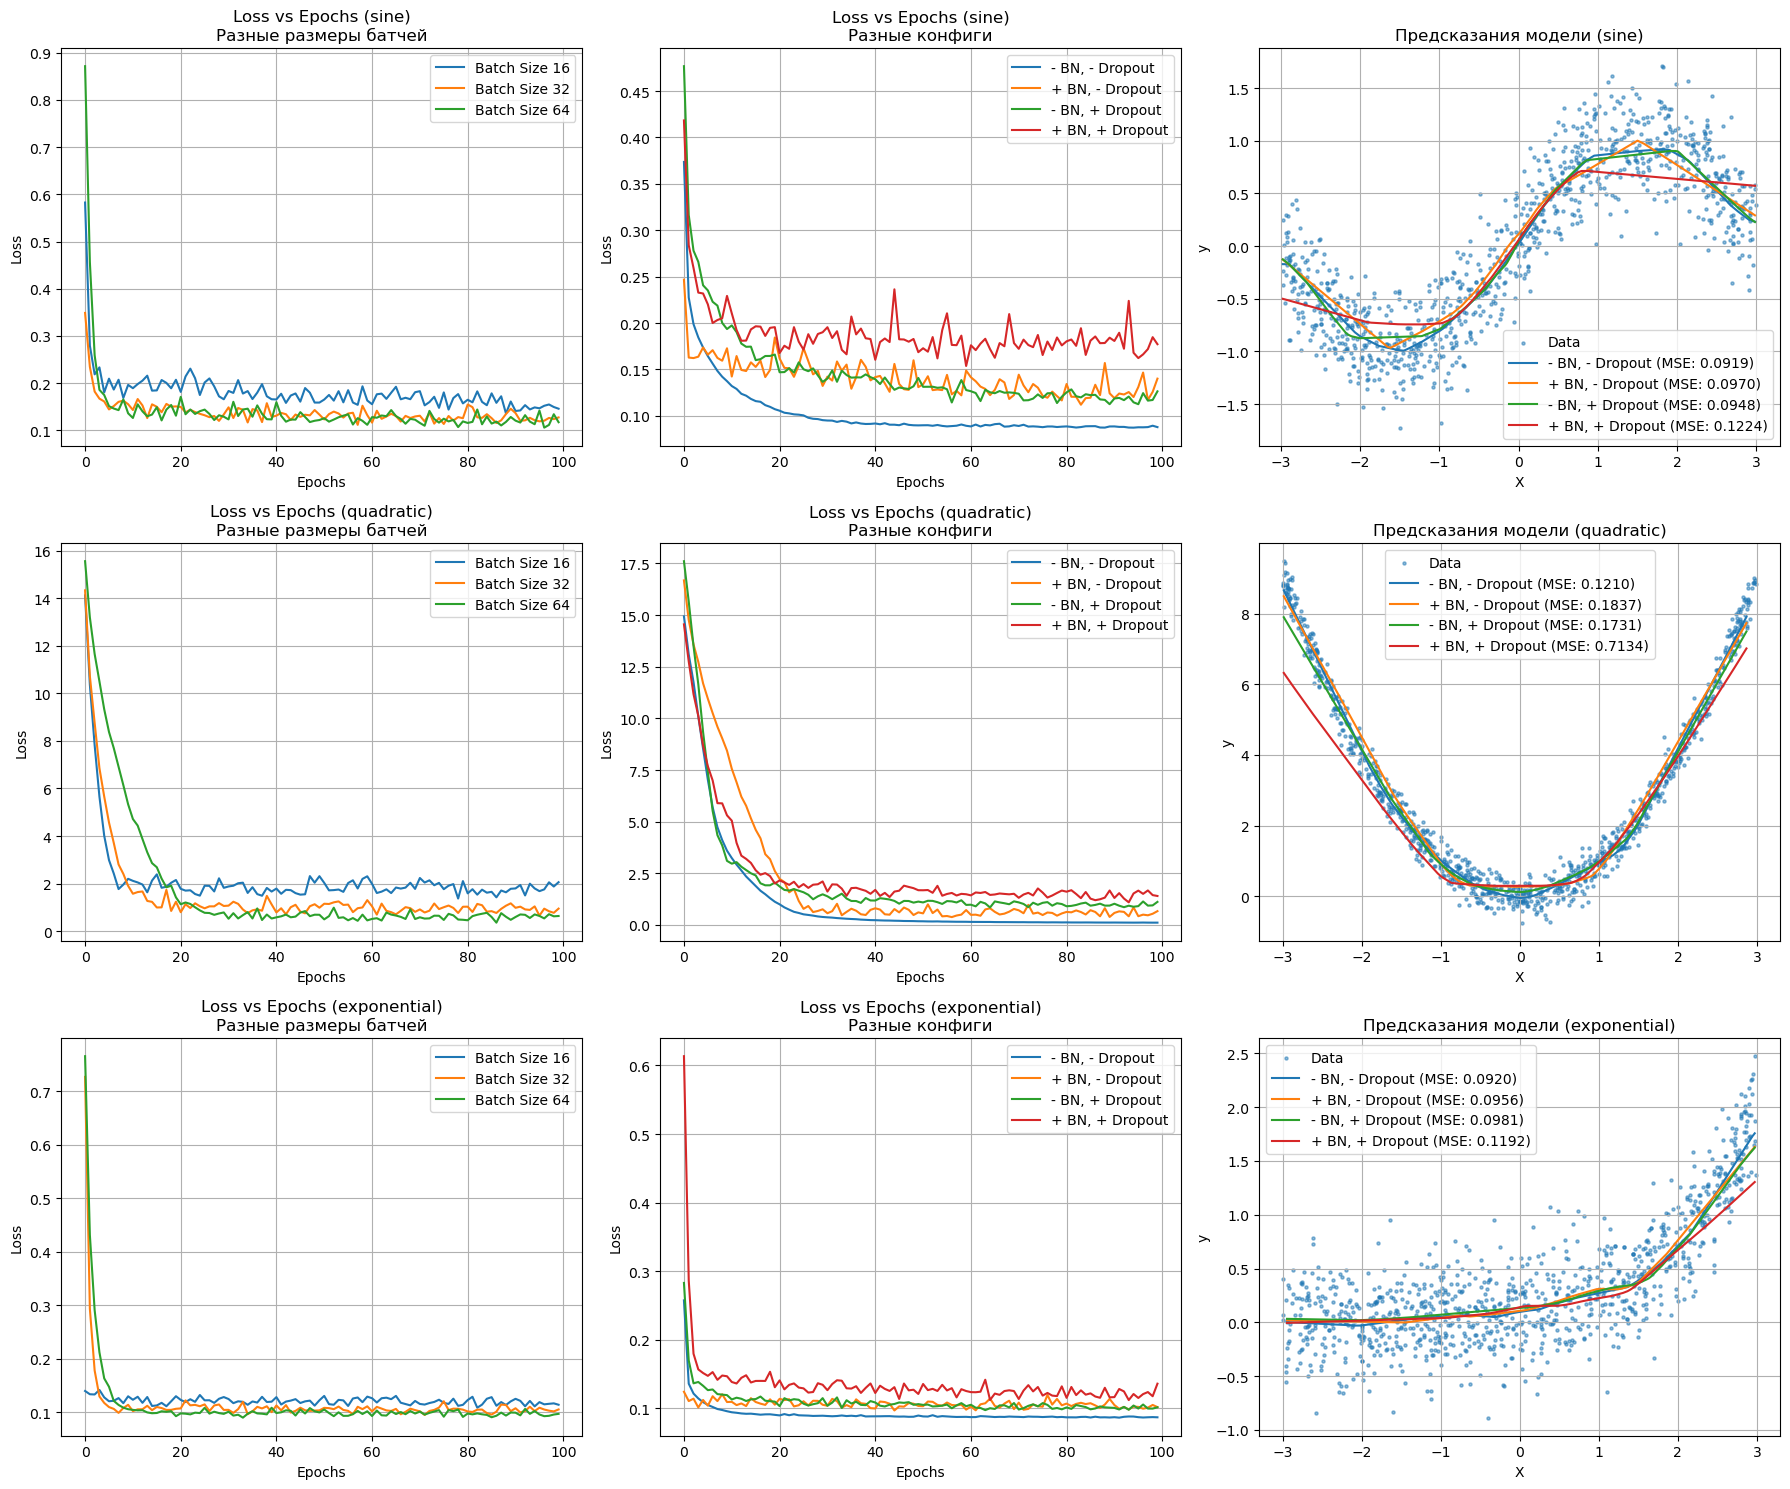


=== Результаты ===

For sine dataset:
Лучший размер батча: 32
Лучшая версия: - BN, - Dropout с MSE: 0.0919
для этого набора данных отсев более эффективен, чем батч норм

For quadratic dataset:
Лучший размер батча: 64
Лучшая версия: - BN, - Dropout с MSE: 0.1210
для этого набора данных отсев более эффективен, чем батч норм

For exponential dataset:
Лучший размер батча: 32
Лучшая версия: - BN, - Dropout с MSE: 0.0920
батч нормализация для этого набора данных более эффективна, чем отсев


In [51]:
function_types = ['sine', 'quadratic', 'exponential']
all_datasets = []

for func_type in function_types:
    print(f"\n=== Генерация {func_type} вида датасета ===")
    dataset = generate_nonlinear_data(function_type=func_type)
    all_datasets.append(dataset)

part1_results_all = []
part2_results_all = []
best_batch_sizes = []

for i, (func_type, dataset) in enumerate(zip(function_types, all_datasets)):
    X_train, y_train, X_test, y_test, _, _ = dataset
    
    print(f"\n\n=== 1 часть. Эксперименты с {func_type} датасетом ===")
    part1_results, best_batch_size = run_batch_size_experiments(X_train, y_train, X_test, y_test)
    part1_results_all.append(part1_results)
    best_batch_sizes.append(best_batch_size)
    print(f"\n=== 2 часть экспериментов с  {func_type} датасетом с лучшим батч сайзом {best_batch_size} ===")
    part2_results = run_configuration_experiments(X_train, y_train, X_test, y_test, best_batch_size)
    part2_results_all.append(part2_results)

visualize_results(all_datasets, part1_results_all, part2_results_all, function_types)

print("\n=== Результаты ===")
for i, func_type in enumerate(function_types):
    print(f"\nFor {func_type} dataset:")
    print(f"Лучший размер батча: {best_batch_sizes[i]}")
    
    best_config = min(part2_results_all[i].items(), key=lambda x: x[1]['mse'])
    print(f"Лучшая версия: {best_config[0]} с MSE: {best_config[1]['mse']:.4f}")
    
    bn_no_dropout_mse = part2_results_all[i]['+ BN, - Dropout']['mse']
    no_bn_dropout_mse = part2_results_all[i]['- BN, + Dropout']['mse']
    
    if bn_no_dropout_mse < no_bn_dropout_mse:
        print("батч нормализация для этого набора данных более эффективна, чем отсев")
    else:
        print("для этого набора данных отсев более эффективен, чем батч норм")

# Выводы

## Размер батча (Часть 1)
- Для регрессии синусоидальной функции лучший размер батча: 32
- Для квадратичной регрессии лучший размер батча: 64
- Для экспоненциальной регрессии лучший размер батча: 32

## Конфигурации модели (Часть 2)

### Синусоидальная функция:
- (batch=32):

        - BN, - Dropout: 0.0919 (лучший)
        + BN, - Dropout: 0.0970
        - BN, + Dropout: 0.0948
        + BN, + Dropout: 0.1224

### Квадратичная функция:
-  (batch=64):

        - BN, - Dropout: 0.1210 (лучший)
        + BN, - Dropout: 0.1837
        - BN, + Dropout: 0.1731
        + BN, + Dropout: 0.7134 (сильно хуже)

### Экспоненциальная функция:
-  (batch=32):

        - BN, - Dropout: 0.0920 (лучший)
        + BN, - Dropout: 0.0956
        - BN, + Dropout: 0.0981
        + BN, + Dropout: 0.1192
        

**Во всех трёх случаях лучшим оказался самый простой вариант: без Batch Normalization и без Dropout**

При слишком маленьком батче (16) возникает сильный шум в оценках градиента, что мешает стабильной сходимости => MSE высокий.


Синус и экспонента дают сравнительно низкие ошибки (MSE около 0.09–0.10)

Квадратичная функция имеет больший разброс значений (от 0 до 9) и чуть больший шум, поэтому итоговая ошибка выше (около 0.12)
